# Evaluating Divergences in Algorithm Output under Fixed Logic Assumption

Consider an algorithm running on some input data and producing a list of numbers as the result
of a complex calculation.
It is not uncommon when a simple refactoring of the code or an introduction of a "technical" change
(i.e. a change that is not expected to affect the logic of the algorithm) can lead to differences
in the algorithm's output. 
Examples of such code modification can include, for example, a change in precision of some
internal calculations or change in compilation flags affecting certain CPU instructions.
If the algorithm is complex and not readily available for inspection one way to gain confidence
in the new result is to inspect the differences in the output caused by the proposed change.

In statistics and information theory, a **statistical distance** quantifies the difference between
two probability distributions or samples. In this study we would like to consider a few popular
statistical distances to measure the divergence in the programs results and see how they can be
applied to the cases where the reproducibility of the algorithm's output is important.

In particular, we calculate the **Kolmogorov-Smirnov** (KS) and **Wasserstein** metrics.

  - The KS test is a general nonparametric method that can be used to check whether two data
    samples come from the same underlying distribution. However, the KS metric used in the
    test can be applied to measure similarity of any two arbitrary samples. 
    
    $$ D = \sup_x |F(x) - G(x)| $$
    
    where $F$ and $G$ are cumulative 
    
  - Similarly, the Wasserstein metric, also know as the earth mover's distance (EMD), measures
    the minimal amount of "work" needed to be done in order to convert one sample into the other.
    
    $$ W = \int |F(x) - G(x)| dx $$

## Modeled Samples

Let's generate a few samples with $N$ numbers each:

  - $R$ and $I$ are independent samples with values uniformly distributed between 0 and 1
  - $C$ and $U$ are sets of samples generated from the $R$ and $I$ samples respectively by
  disturbing their individual values at a certain level

By construction $R$ is highly correlated with every sample $C_i$. In contrast, $R$ and every sample
$U_i$ are completely uncorrelated.

Include the following dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import uniform

import tk

In [2]:
#mpl.rc('figure', dpi=120)

Fix random seed for reproducibility

In [3]:
np.random.seed(12345)

Set the number of points in our model sample

In [4]:
N = 1000
spacing = 1./N

### Reference Samples

Generate the reference sample $R$ and another completely uncorrelated sample $I$.
Both samples are drawn from the same uniform distribution in the range [0, 1]

In [5]:
R = uniform.rvs(0, 1, size=N)
I = uniform.rvs(0, 1, size=N)

Create sorted copies $R_s$ and $I_s$ of the $R$ and $I$ samples respectively

In [6]:
R_s = np.sort(R)
I_s = np.sort(I)

Now we can visualize the samples by making the following scatter plots

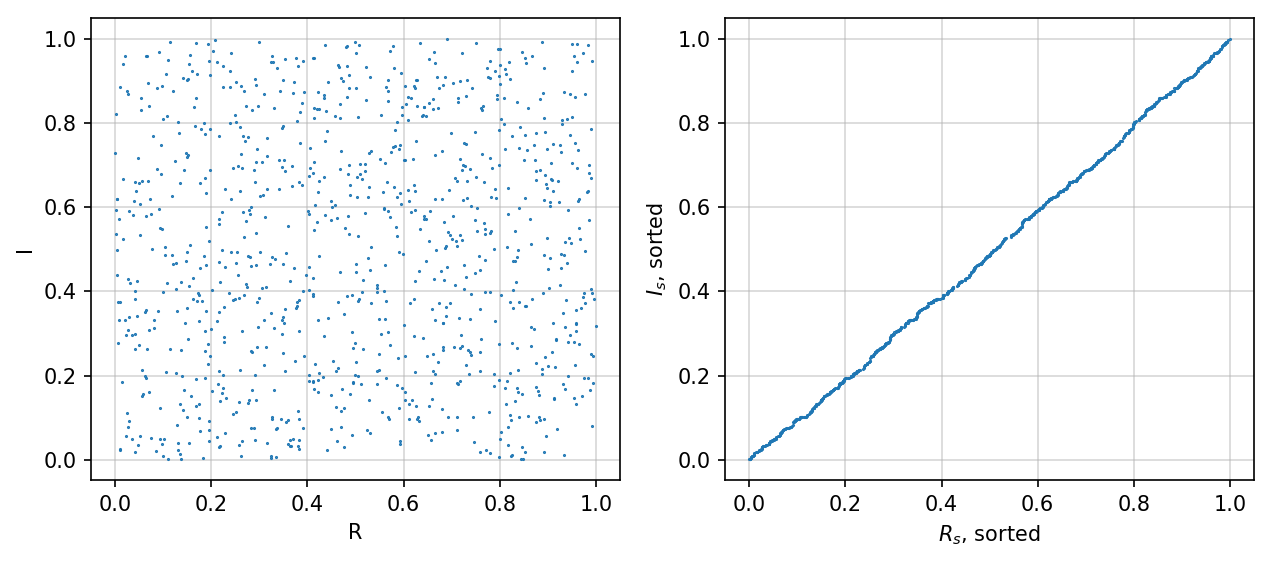

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(R, I, '.', ms=1)
ax1.set_xlabel('R')
ax1.set_ylabel('I')
ax1.grid()
ax2.plot(R_s, I_s, '.', ms=1)
ax2.set_xlabel('$R_s$, sorted')
ax2.set_ylabel('$I_s$, sorted')
ax2.grid()
plt.show()

Let's plot the relative difference between the neighboring values in $R$ and $R_s$.
From the plot we see that most of the values randomly picked from the unsorted sample
will differ from their respective neighbor by at least 0.001, i.e. the expected average `spacing` 
between the values, represented by the red line

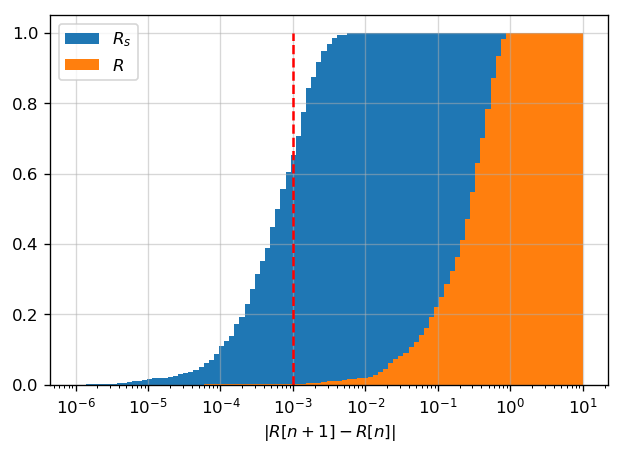

In [8]:
bins = np.logspace(-6, 1, 100)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=120)

ax.hist(np.abs(np.diff(R_s)), bins=bins, cumulative=True, density=True, label='$R_s$')
ax.hist(np.abs(np.diff(R)), bins=bins, cumulative=True, density=True, label='$R$')
ax.plot([spacing, spacing], [0,1], 'r--')

ax.semilogx()
ax.grid()
ax.legend()
ax.set_xlabel(r'$\left| R[n+1] - R[n] \right|$')
plt.show()

### Smeared Samples

Define a few noise levels relative to the nominal spacing defined above.
The values in the original distribution will be shuffled according to the specified levels.

In [56]:
rel_shuffle = np.array([0.01, 0.1, 1, 10, 100])

Using $R$ and $I$ generate two sets of samples $C$ and $U$ with the various levels of noise introduced to the individual values

In [57]:
C = {}
U = {}

for shuffle in rel_shuffle[::-1]:
    abs_shuffle = shuffle*spacing
    C[shuffle] = R + uniform.rvs(loc=-0.5*abs_shuffle, scale=abs_shuffle, size=N)
    U[shuffle] = I + uniform.rvs(loc=-0.5*abs_shuffle, scale=abs_shuffle, size=N)

In [58]:
for shuffle, c in C.items():
    print(shuffle, len(c))

100.0 1000
10.0 1000
1.0 1000
0.1 1000
0.01 1000


#### Correlated

The upper scatter plots simply visualise $R$ vs $C_i$ with and without sorting.
The lower plots show cumulative distributions of the absolute element-wise difference for sorted and unsorted $R$ and $C_i$ samples

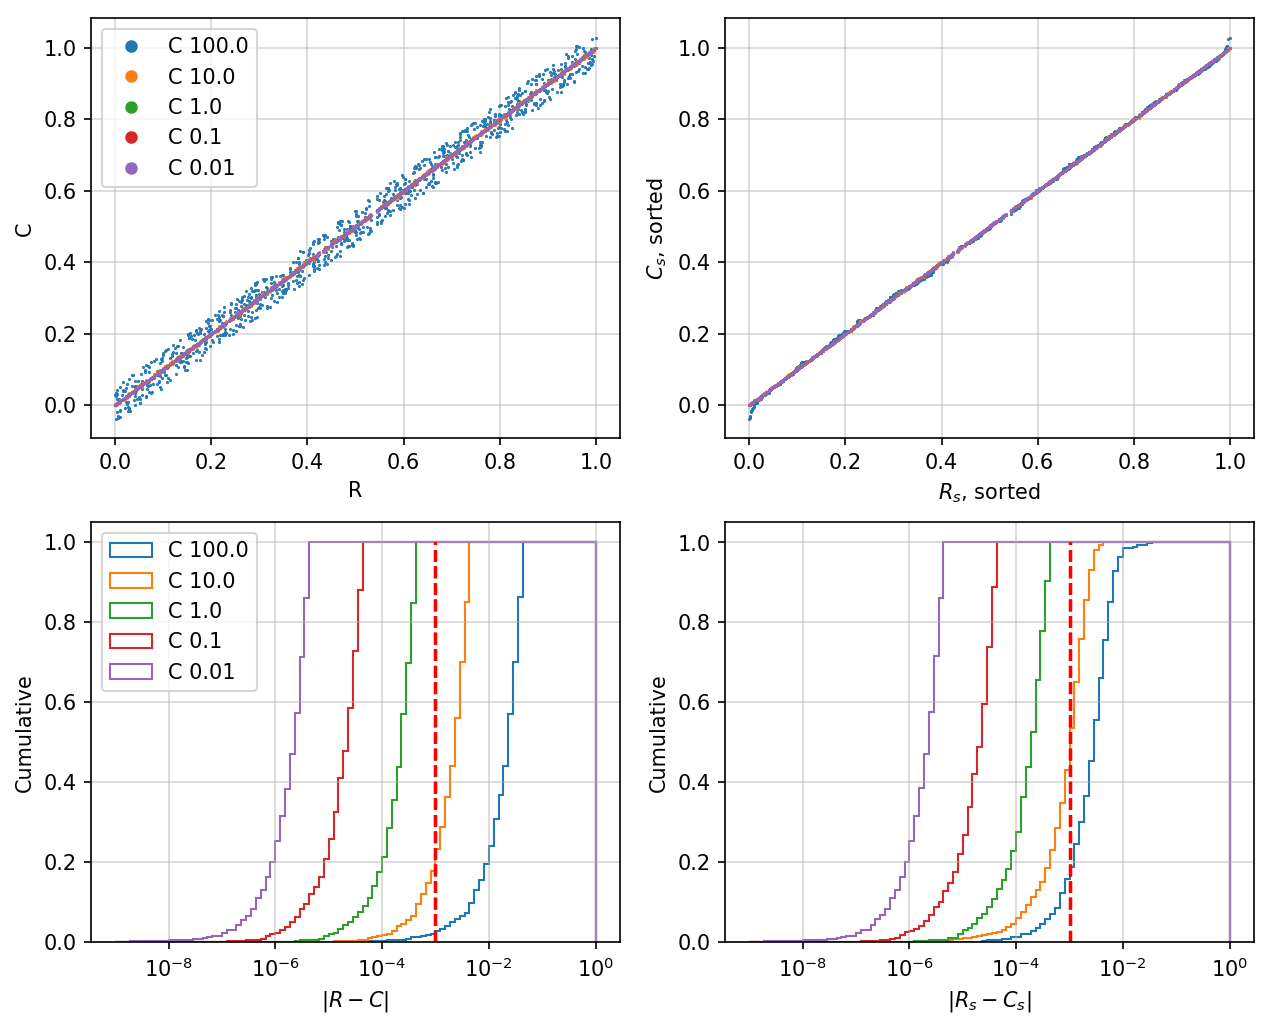

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
tk.plot_R_vs_S(R, C, spacing, 'C', axes)

#### Uncorrelated

Similar to the above but using $R$ and $U_i$ samples.

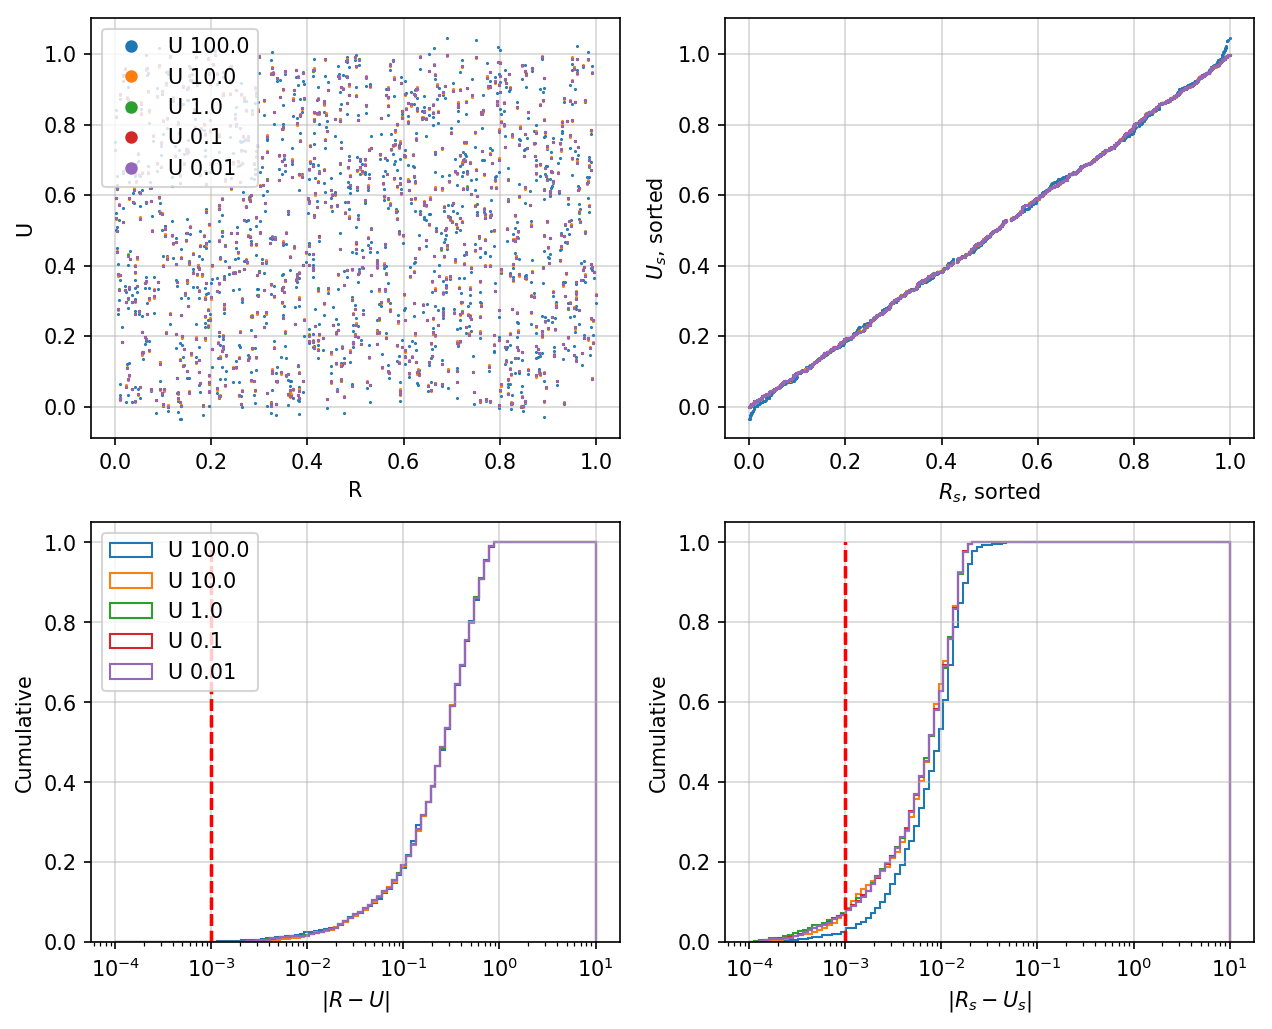

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
tk.plot_R_vs_S(R, U, spacing, 'U', axes)

### Samples with Removed Elements

In [61]:
rm_frac = [0.1, 1, 10, 50]
M = {}

for rmf in rm_frac:
    m = C[0.1]
    todel = int(len(m)*rmf/100.)
    indel = np.random.choice(len(m), todel, replace=False)
    M[rmf] = np.delete(m, indel)
    #print(f'{rmf:8}, {shuffle:8}, {len(ss[shuffle]):8}')

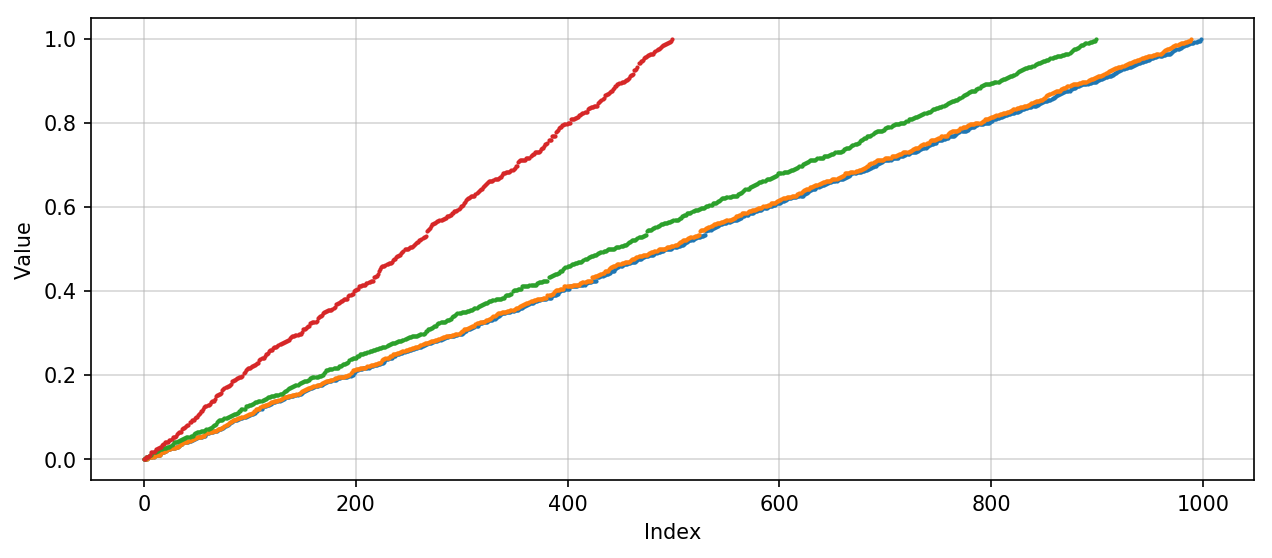

In [62]:
fig = plt.figure(figsize=(10,4))
for _, m in M.items():
    plt.plot(np.sort(m), '.', ms=2)
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid() 

### Samples with Significantly Modified Elements

In [63]:
change_frac = [50, 10, 1, 0.1]
J = {}

def modifyvalue(v):
    if (v <= 0.25):   mymin, mymax = 0.5, 0.5
    elif (v >= 0.75): mymin, mymax = 0, 0.5
    elif (np.random.choice(2)):
        mymin, mymax = 0, v-0.25 
    else:
        mymin, mymax = v+0.25, 1-(v+0.25)
        
    return uniform.rvs(mymin, mymax, size=1)[0]

for chf in change_frac:
    j = np.copy(C[0.1])
    n_change = int(len(j)*chf/100.)
    indices = np.random.choice(len(j), n_change, replace=False)
    j[indices] = [modifyvalue(v) for v in j[indices]]
    J[chf] = j

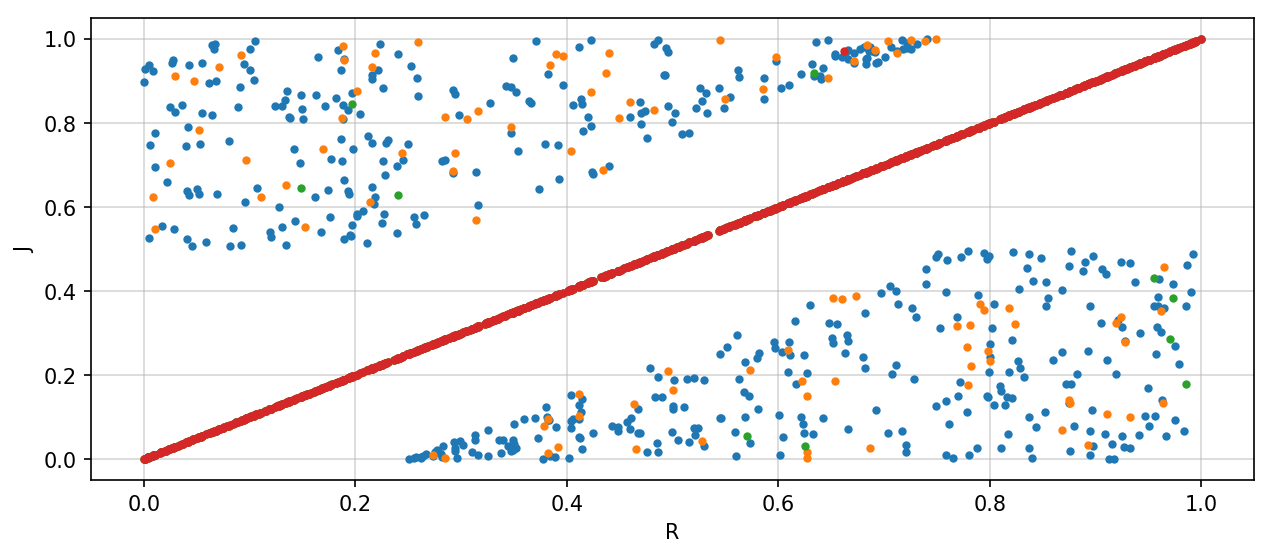

In [64]:
fig = plt.figure(figsize=(10,4))
for _, j in J.items():
    plt.plot(R, j, '.')
plt.xlabel('R')
plt.ylabel('J')
plt.grid() 

## Statistical Distance

Now look at the KS statistic and probability

### KS  and Wasserstein Metrics

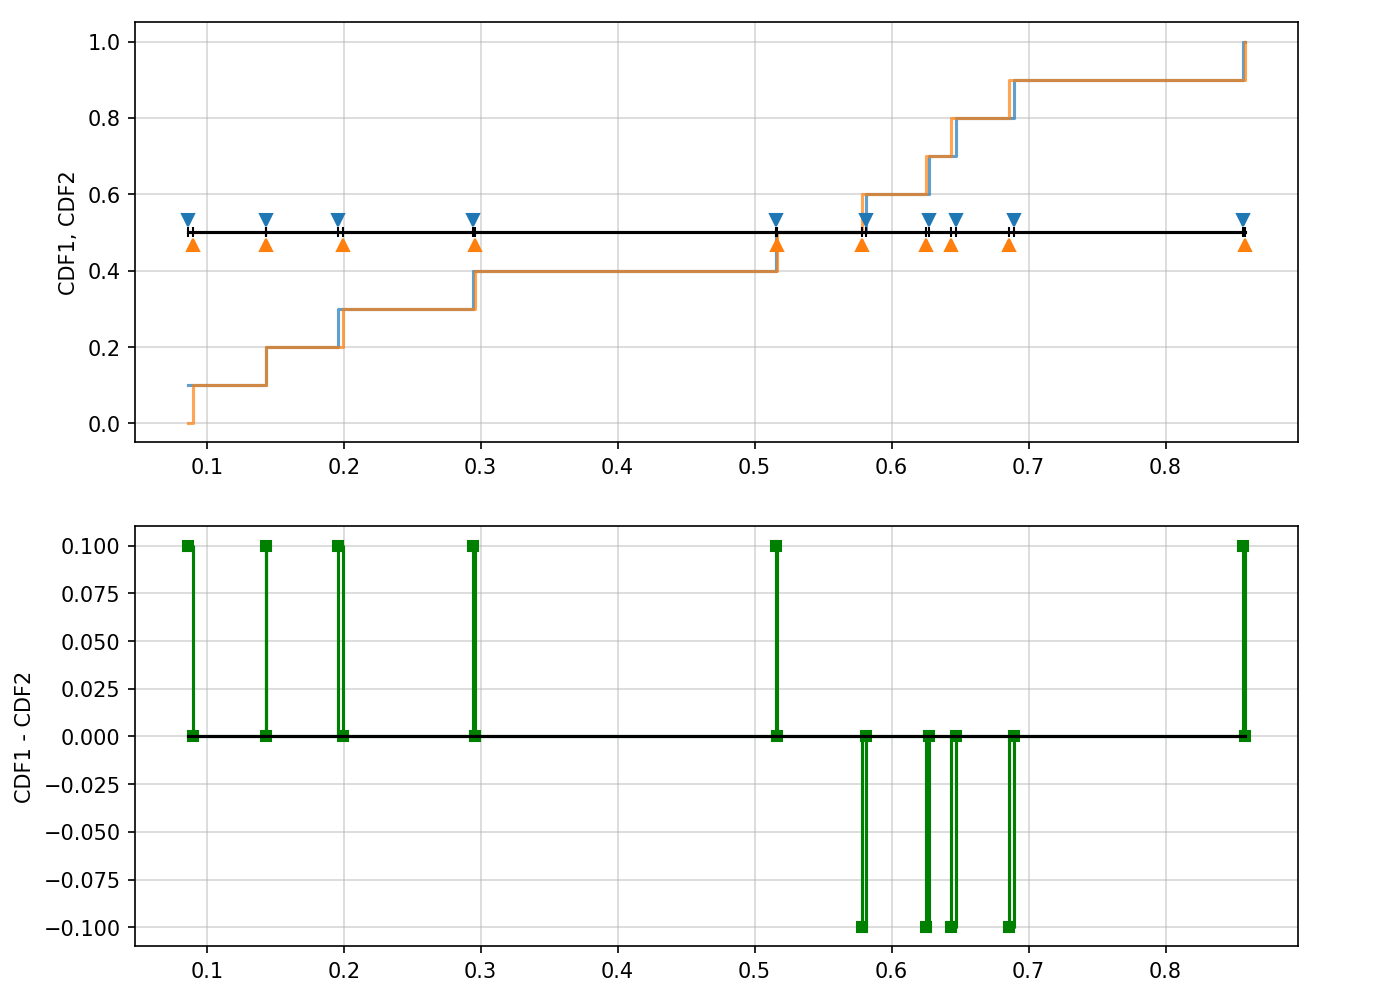

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

rmin = 100
rmax = 110
d1 = R[rmin:rmax]
d2 = C[10][rmin:rmax]

tk.plot_cumpdf(d1, d2, ax1, ax2)

### Calculate Metrics for Model Samples 

In [74]:
seq = tk.contseq(R, J[0.1])

array([1, 1, 1, ..., 2, 2, 1])

In [75]:
(seq > 2).sum()

9

In [123]:
def calc_metrics(data1, data2):
    ks = stats.ks_2samp(data1, data2)
    wd = stats.wasserstein_distance(data1, data2)
    
    seq = tk.contseq(data1, data2)
    sm1 = (seq == 1).sum()/len(data1)/2
    sm2 = (seq == 2).sum()/len(data1)
    sm3 = (seq > 2).sum()/len(data1)
    sm = 1 - sm1 - sm2
    
    return (ks[0], wd, sm1, sm2, sm3, sm)

In [140]:
stat_dists = [ (shuffle, len(s)) + calc_metrics(R, s) for shuffle, s in C.items()]

df = pd.DataFrame(stat_dists)
df.columns = ['shf', 'siz', 'ksd', 'wsd', 'sm1', 'sm2', 'sm3', 'sm']
df

,shf,siz,ksd,wsd,sm1,sm2,sm3,sm
0,100.00,1000,0.014,0.003880,0.2285,0.265,0.249,0.5065
1,10.00,1000,0.008,0.001295,0.2540,0.253,0.255,0.4930
2,1.00,1000,0.003,0.000226,0.3875,0.439,0.111,0.1735
3,0.10,1000,0.002,0.000024,0.4910,0.495,0.009,0.0140
4,0.01,1000,0.001,0.000002,0.4955,0.504,0.000,0.0005


In [139]:
stat_dists = [ (shuffle, len(s)) + calc_metrics(R, R)]

df = pd.DataFrame(stat_dists)
df.columns = ['shf', 'siz', 'ksd', 'wsd', 'sm1', 'sm2', 'sm3', 'sm']
df

,shf,siz,ksd,wsd,sm1,sm2,sm3,sm
0,0.01,500,0.0,0.0,0.0,0.0,0.001,1.0


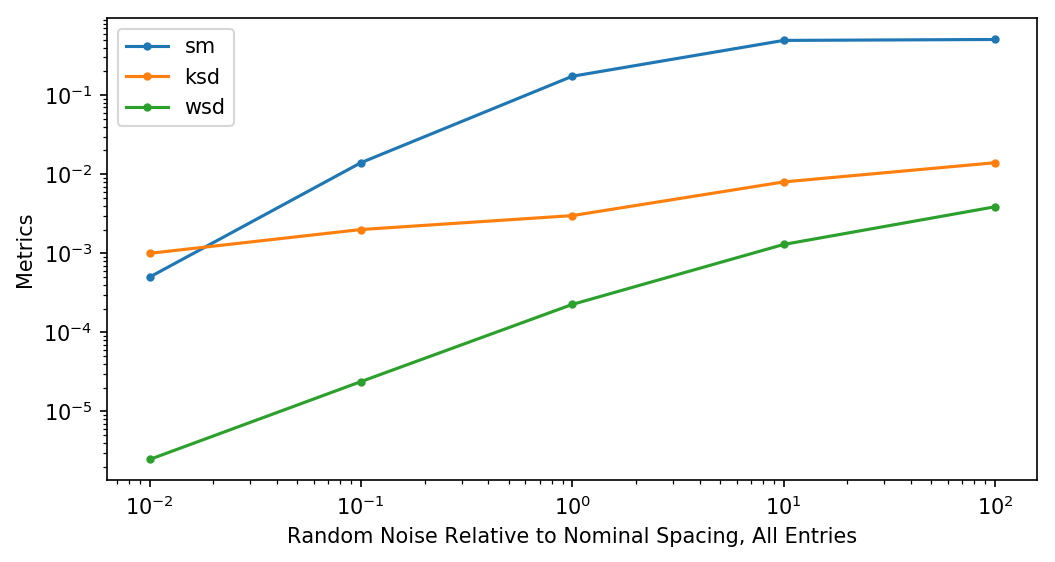

In [143]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))

ax = axs
ax.plot(df.shf, df.sm, '.-')
ax.plot(df.shf, df.ksd, '.-')
ax.plot(df.shf, df.wsd, '.-')
        
ax.set_xlabel('Random Noise Relative to Nominal Spacing, All Entries')
ax.set_ylabel('Metrics')
ax.semilogx()
ax.semilogy()
ax.legend()

In [144]:
stat_dists = [ (rmf, len(s)) + calc_metrics(R, s) for rmf, s in M.items()]

df = pd.DataFrame(stat_dists)
df.columns = ['rmf', 'siz', 'ksd', 'wsd', 'sm1', 'sm2', 'sm3', 'sm']
df

,rmf,siz,ksd,wsd,sm1,sm2,sm3,sm
0,0.1,999,0.002456,0.000275,0.490,0.494,0.010,0.016
1,1.0,990,0.003071,0.000647,0.491,0.487,0.011,0.022
2,10.0,900,0.013333,0.004302,0.447,0.442,0.038,0.111
3,50.0,500,0.018000,0.005767,0.277,0.207,0.134,0.516


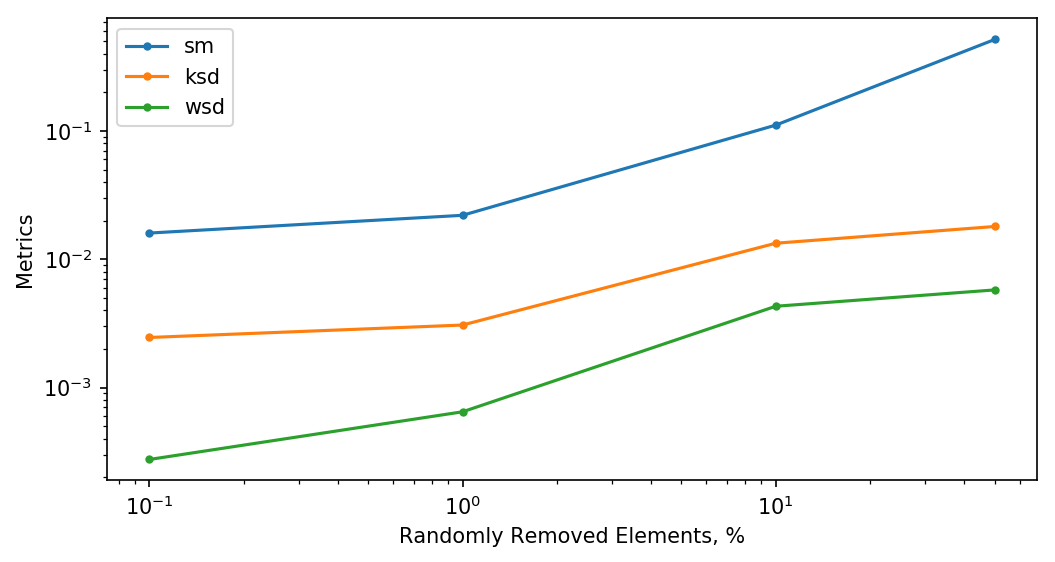

In [145]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))

ax = axs
ax.plot(df.rmf, df.sm, '.-')
ax.plot(df.rmf, df.ksd, '.-')
ax.plot(df.rmf, df.wsd, '.-')
        
ax.set_xlabel('Randomly Removed Elements, %')
ax.set_ylabel('Metrics')
ax.semilogx()
ax.semilogy()
ax.legend()

In [162]:
stat_dists = [ (chf, len(s)) + calc_metrics(R, s) for chf, s in J.items()]

df = pd.DataFrame(stat_dists)
df.columns = ['chf', 'siz', 'ksd', 'wsd', 'sm1', 'sm2', 'sm3', 'sm']
df

,chf,siz,ksd,wsd,sm1,sm2,sm3,sm
0,50.0,1000,0.086,0.039738,0.3730,0.316,0.173,0.3110
1,10.0,1000,0.023,0.009742,0.4695,0.451,0.050,0.0795
2,1.0,1000,0.005,0.001896,0.4865,0.490,0.015,0.0235
3,0.1,1000,0.003,0.000326,0.4910,0.495,0.009,0.0140


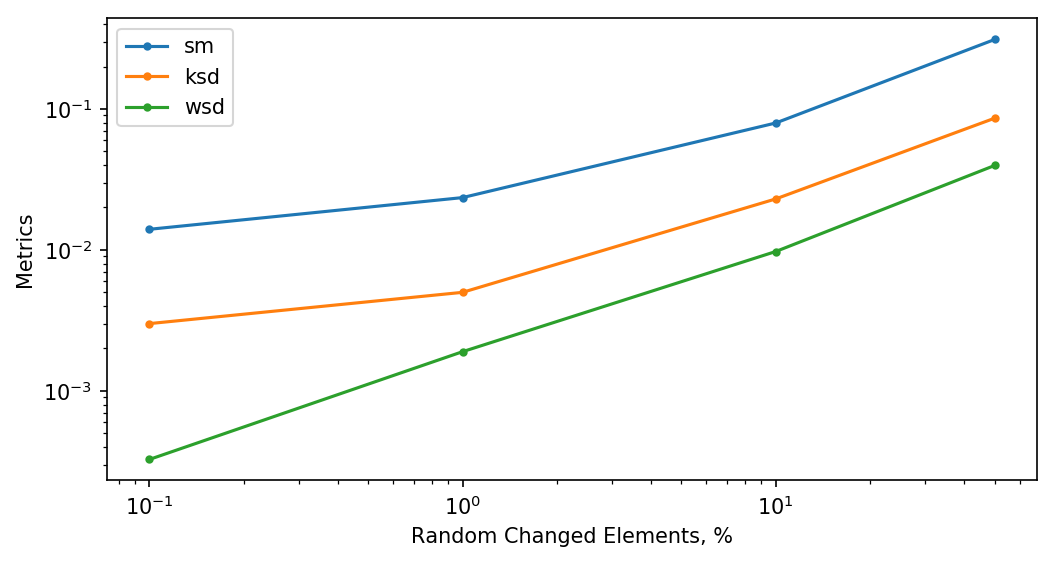

In [165]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))

ax = axs
ax.plot(df.chf, df.sm, '.-')
ax.plot(df.chf, df.ksd, '.-')
ax.plot(df.chf, df.wsd, '.-')
        
ax.set_xlabel('Random Changed Elements, %')
ax.set_ylabel('Metrics')
ax.semilogx()
ax.semilogy()
ax.legend()

fig, axs = plt.subplots(2, 2, figsize=(10,8))

ax = axs[0,0]
for shf in rel_shuffle:
    select = df.shf == shf
    dfsel = df.loc[select]
    wsd = dfsel.wsd.values
    wsd[wsd==0] = 1e-6 #np.nan
    x = dfsel.rmf.values
    x[x==0] = 1e-3
    ax.plot(x, wsd, '*-', label=f'rel. noise {shf}')
        
ax.set_xlabel('Random Fraction Removed, %')
ax.set_ylabel('W Distance')
ax.semilogx()
ax.semilogy()
ax.legend()

ax = axs[0,1]
for rmf in rm_frac:
    select = df.rmf == rmf
    dfsel = df.loc[select]
    wsd = dfsel.wsd.values
    wsd[wsd==0] = 1e-6 #np.nan
    x = dfsel.shf.values
    x[x==0] = 1e-3
    ax.plot(x, wsd, '*-', label=f'removed {rmf}%')
        
ax.set_xlabel('Random Relative Noise, %')
ax.set_ylabel('W Distance')
ax.semilogx()
ax.semilogy()
ax.legend()

ax = axs[1,0]
for shf in rel_shuffle:
    select = df.shf == shf
    dfsel = df.loc[select]
    ksd = dfsel.ksd.values
    ksd[ksd==0] = 1e-4 #np.nan
    x = dfsel.rmf.values
    x[x==0] = 1e-3
    ax.plot(x, ksd, 'o-', label=f'rel. noise {shf}')
        
ax.set_xlabel('Random Fraction Removed, %')
ax.set_ylabel('KS Distance')
ax.semilogx()
ax.semilogy()
ax.legend()

ax = axs[1,1]
for rmf in rm_frac:
    select = df.rmf == rmf
    dfsel = df.loc[select]
    ksd = dfsel.ksd.values
    ksd[ksd==0] = 1e-4 #np.nan
    x = dfsel.shf.values
    x[x==0] = 1e-3
    ax.plot(x, ksd, 'o-', label=f'removed {rmf}%')
        
ax.set_xlabel('Random Relative Noise, %')
ax.set_ylabel('KS Distance')
ax.semilogx()
ax.semilogy()
ax.legend()

plt.show()

## Matching Closest Elements

In [26]:
import importlib
importlib.reload(tk)

<module 'tk' from '/Users/dsmirnov/work/pub-docs/star-32-vs-64-build/tk.py'>

In [156]:
# good example
#rmin = 77
#rmax = rmin+20

#rmin = 0
#rmax = 1000

#data1 = np.sort(R[rmin:rmax])
#data2 = np.sort(C[0.1][rmin:rmax])
data1 = R
data2 = J[0.1]
#data1 = d1
#data2 = d2
#data1 = np.linspace(0, 0.9, 10)
#data1[3] =  0.18
#data2 = np.linspace(0, 0.9, 10) + 0.02
##data2 = np.array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])
#data2[3] = 0.44
#data2[5] = 0.48
#data2

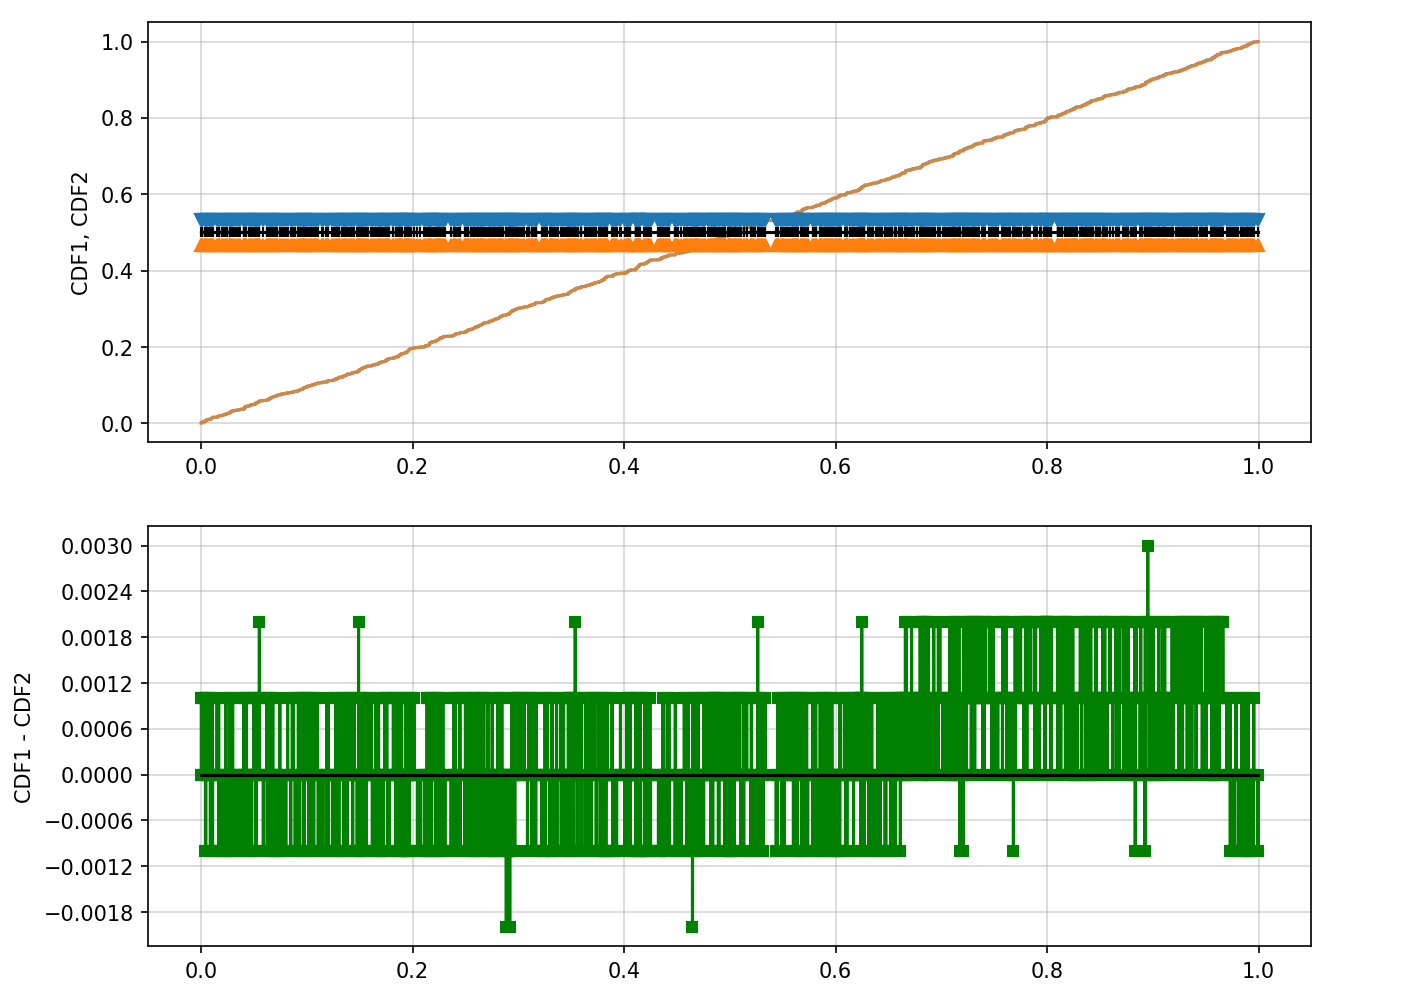

In [157]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
tk.plot_cumpdf(data1, data2, ax1, ax2)

In [158]:
seq = tk.contseq(data1, data2)

In [159]:
m1, m2, rms, nunm1, nunm2 = tk.match_closest(data1, data2)
assert(len(m1) == len(m2))
rms, nunm1, nunm2

(3.368864121968902e-05, 18, 18)

In [160]:
mmask1 = np.in1d(range(len(data1)), m1)
mmask2 = np.in1d(range(len(data2)), m2)

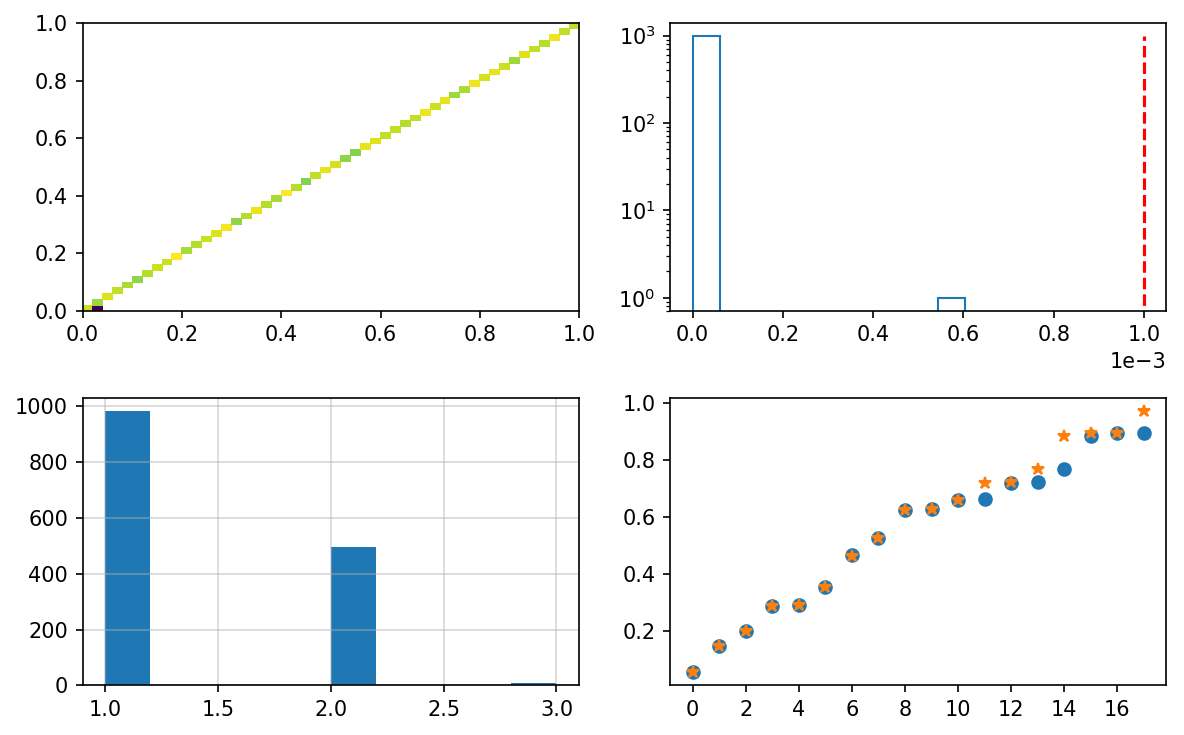

In [170]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(2, 2, figsize=(8,5))

ax[0,0].hist2d(data1[m1], data2[m2], bins=50, norm=mpl.colors.LogNorm())
#ax[0,1].plot(data1[m1], data2[m2], '.')
h, _, _ = ax[0,1].hist(np.abs(data1[m1] - data2[m2]), histtype='step')
ax[0,1].plot([spacing, spacing], [0, np.max(h)], 'r--')
ax[0,1].semilogy()
ax[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))

#ax[1,0].hist(seq, bins=np.arange(np.max(seq)+2)-0.5, histtype='step')
ax[1,0].hist(seq)
#ax[1,0].semilogy()
ax[1,0].grid()

ax[1,1].plot(np.sort(data1[~mmask1]), 'o', np.sort(data2[~mmask2]), '*')
ax[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()

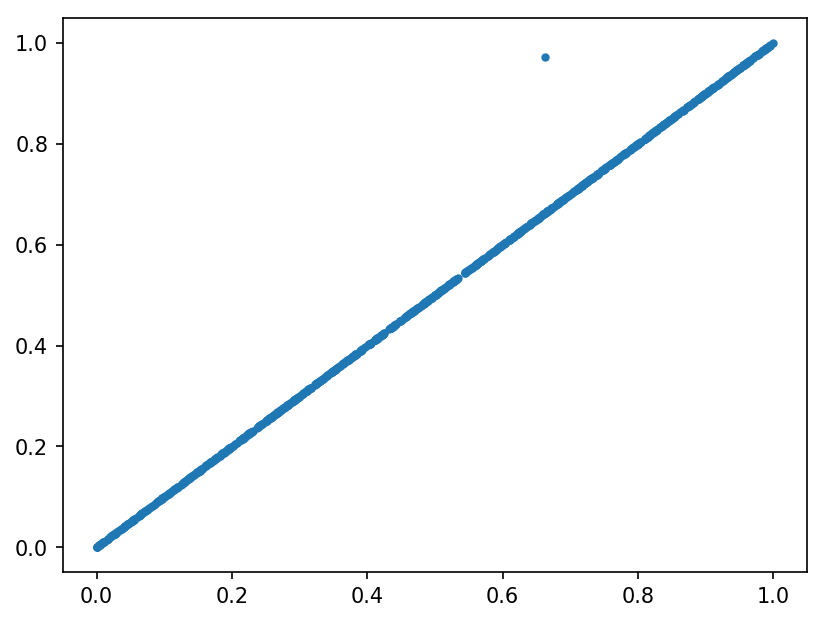

In [166]:
plt.plot(C[0.1], J[0.1], '.')

In [309]:
from scipy.spatial import distance

def match_closest_unsorted(data1, data2):
    
    if len(data1.shape) < 2:
        indices1 = np.arange(len(data1))/len(data1)
        tuple1 = list(zip(indices1, data1))
        
    if len(data2.shape) < 2:
        indices2 = np.arange(len(data2))/len(data2)
        tuple2 = list(zip(indices2, data2))

    dists = distance.cdist(tuple1, tuple2) 
    ind = np.unravel_index(np.argsort(dists, axis=None), dists.shape)
    ind = np.stack(ind, axis=-1)
    
    uniq = [ind[0]]
    for coords in ind:
        #print(coords, len(coords))
        is_uniq = np.all(np.array([np.all(u-coords) for u in uniq]))
        
        if (is_uniq):
            uniq.append(coords)
         
    return ind, np.array(uniq), dists

In [327]:
d1 = data1[100:105]
d2 = data2[100:105]
d1 = np.array([0, 1, 2, 3])
d2 = np.array([2, 4, 6, 8])

print(d1, d2)
ind, uind, dists = match_closest_unsorted(d1, d2)

#_, indices = np.unique(ind[0], return_index=True)

print(dists)
#print(dists[uind.Tlist()])
print(dists[tuple(uind.T)])
tuple(uind.T)
#ind[0], ind[1]

[0 1 2 3] [2 4 6 8]
[[2.         4.00780489 6.02079729 8.03507934]
 [1.03077641 3.         5.0062461  7.01783442]
 [0.5        2.01556444 4.         6.00520607]
 [1.25       1.11803399 3.01039864 5.        ]]
[0.5        1.11803399 5.0062461  8.03507934]


(array([2, 3, 1, 0]), array([0, 1, 2, 3]))

## Appendix

### Write samples to text files

In [ ]:
def write_values_to_file(array, fname):
    with open(f'{fname}.txt', 'w') as f:
        for a in array:
            f.write(f'{a}\n')

In [ ]:
#write_values_to_file(data1, "data1")
#write_values_to_file(data2, "data2")